In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# Setup Kaggle API and Install Required Packages
!pip install -q kaggle
!pip install -q opencv-python scikit-learn joblib matplotlib numpy pandas

# Create .kaggle directory and upload credentials
import os
!mkdir -p ~/.kaggle

# Upload kaggle.json (You need to upload this from your Kaggle account)
# Instructions: Go to Kaggle.com -> Settings -> API -> Create New Token (downloads kaggle.json)
from google.colab import files
print("Upload your kaggle.json file:")
files.upload()

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vanxodus305","key":"d30067f4857ddce645f520970145350a"}'}

In [17]:
# Configure Kaggle API
import os
import shutil

# Move kaggle.json to ~/.kaggle/ directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Download the cats and dogs dataset
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset -p /tmp/dataset --unzip

print("Dataset downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 98% 769M/788M [00:08<00:00, 89.0MB/s]
100% 788M/788M [00:08<00:00, 101MB/s] 
Dataset downloaded successfully!


Number of Cat images: 500
Number of Dog images: 500
Total images: 1000


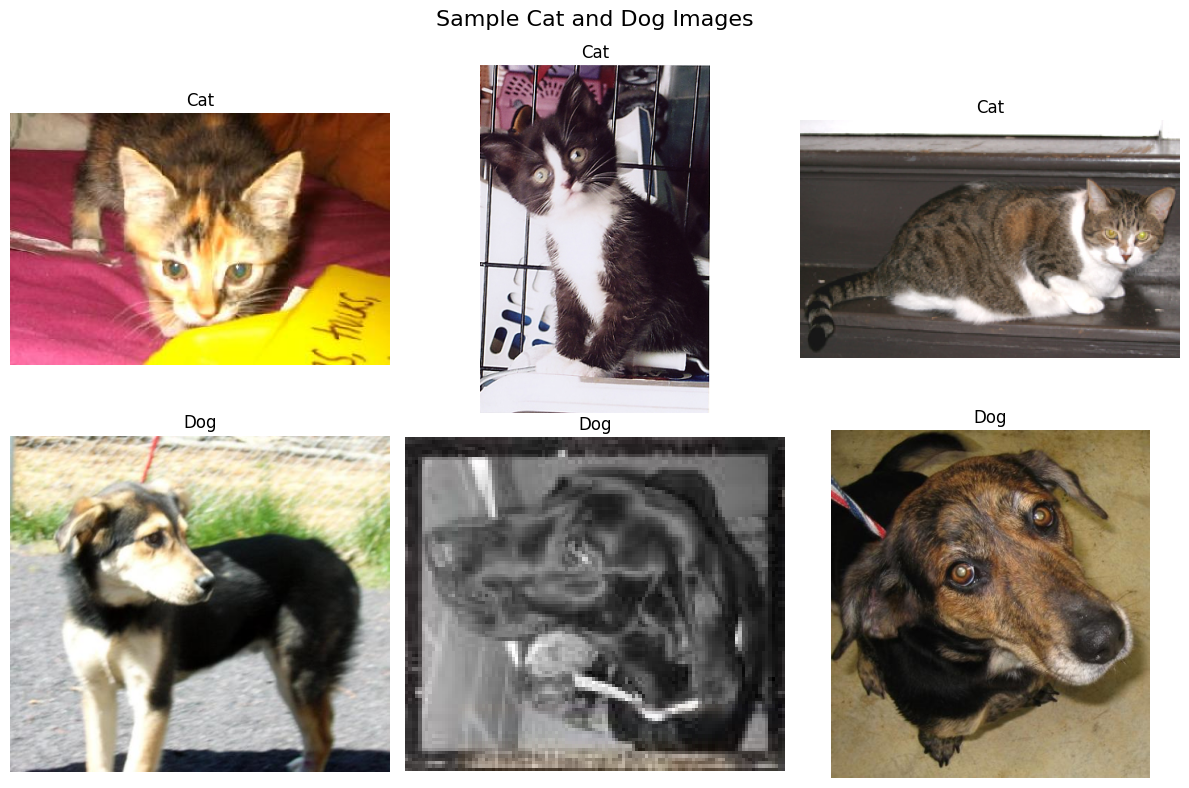

In [18]:
# Load and Explore Dataset
dataset_path = '/tmp/dataset/PetImages'

# Check directory structure
cat_dir = os.path.join(dataset_path, 'Cat')
dog_dir = os.path.join(dataset_path, 'Dog')

# Limit to 500 per class for training efficiency
cat_images = os.listdir(cat_dir)[:500]
dog_images = os.listdir(dog_dir)[:500]

print(f"Number of Cat images: {len(cat_images)}")
print(f"Number of Dog images: {len(dog_images)}")
print(f"Total images: {len(cat_images) + len(dog_images)}")

# Display sample images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample Cat and Dog Images', fontsize=16)

for i in range(3):
    cat_path = os.path.join(cat_dir, cat_images[i])
    dog_path = os.path.join(dog_dir, dog_images[i])

    cat_img = cv2.imread(cat_path)
    dog_img = cv2.imread(dog_path)

    if cat_img is not None:
        axes[0, i].imshow(cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title('Cat')
        axes[0, i].axis('off')

    if dog_img is not None:
        axes[1, i].imshow(cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB))
        axes[1, i].set_title('Dog')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Preprocess Images with OpenCV
IMAGE_SIZE = (64, 64)  # Resize all images to 64x64

def load_and_preprocess_images(image_dir, label, limit=500):
    """
    Load and preprocess images from directory
    Returns: feature array and corresponding labels
    """
    features = []
    labels = []
    count = 0

    for image_name in os.listdir(image_dir):
        if count >= limit:
            break

        image_path = os.path.join(image_dir, image_name)
        try:
            # Read image
            img = cv2.imread(image_path)

            if img is None:
                continue

            # Resize image
            img_resized = cv2.resize(img, IMAGE_SIZE)

            # Convert to grayscale for simplicity
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

            # Flatten the image to 1D array
            img_flattened = img_gray.flatten()

            # Normalize pixel values (0-255 to 0-1)
            img_normalized = img_flattened / 255.0

            features.append(img_normalized)
            labels.append(label)
            count += 1

        except Exception as e:
            continue

    return np.array(features), np.array(labels)

# Load cat images (label: 0)
print("Loading cat images...")
cat_features, cat_labels = load_and_preprocess_images(cat_dir, 0, limit=500)

# Load dog images (label: 1)
print("Loading dog images...")
dog_features, dog_labels = load_and_preprocess_images(dog_dir, 1, limit=500)

# Combine features and labels
X = np.vstack([cat_features, dog_features])
y = np.hstack([cat_labels, dog_labels])

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Feature vector size: {X.shape[1]}")  # Should be 64*64 = 4096

Loading cat images...
Loading dog images...
Dataset shape: (1000, 4096)
Labels shape: (1000,)
Feature vector size: 4096


In [20]:
# Prepare Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# Standardize features (important for SVM and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized successfully!")

Training set size: (800, 4096)
Testing set size: (200, 4096)
Training set class distribution: [400 400]
Testing set class distribution: [100 100]

Features standardized successfully!


In [21]:
# Train KNN Model
print("Training KNN Model...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Predictions
knn_train_pred = knn_model.predict(X_train_scaled)
knn_test_pred = knn_model.predict(X_test_scaled)

# Evaluation
knn_train_acc = accuracy_score(y_train, knn_train_pred)
knn_test_acc = accuracy_score(y_test, knn_test_pred)

print(f"KNN Training Accuracy: {knn_train_acc:.4f}")
print(f"KNN Testing Accuracy: {knn_test_acc:.4f}")
print(f"KNN Precision: {precision_score(y_test, knn_test_pred):.4f}")
print(f"KNN Recall: {recall_score(y_test, knn_test_pred):.4f}")
print(f"KNN F1-Score: {f1_score(y_test, knn_test_pred):.4f}")

Training KNN Model...
KNN Training Accuracy: 0.7000
KNN Testing Accuracy: 0.5050
KNN Precision: 0.5053
KNN Recall: 0.4800
KNN F1-Score: 0.4923


In [22]:
# Train Logistic Regression Model
print("Training Logistic Regression Model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Evaluation
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

print(f"Logistic Regression Training Accuracy: {lr_train_acc:.4f}")
print(f"Logistic Regression Testing Accuracy: {lr_test_acc:.4f}")
print(f"Logistic Regression Precision: {precision_score(y_test, lr_test_pred):.4f}")
print(f"Logistic Regression Recall: {recall_score(y_test, lr_test_pred):.4f}")
print(f"Logistic Regression F1-Score: {f1_score(y_test, lr_test_pred):.4f}")

Training Logistic Regression Model...
Logistic Regression Training Accuracy: 1.0000
Logistic Regression Testing Accuracy: 0.4650
Logistic Regression Precision: 0.4598
Logistic Regression Recall: 0.4000
Logistic Regression F1-Score: 0.4278


In [23]:
# Train Random Forest Model
print("Training Random Forest Model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Evaluation
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest Training Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Testing Accuracy: {rf_test_acc:.4f}")
print(f"Random Forest Precision: {precision_score(y_test, rf_test_pred):.4f}")
print(f"Random Forest Recall: {recall_score(y_test, rf_test_pred):.4f}")
print(f"Random Forest F1-Score: {f1_score(y_test, rf_test_pred):.4f}")

Training Random Forest Model...
Random Forest Training Accuracy: 1.0000
Random Forest Testing Accuracy: 0.5650
Random Forest Precision: 0.5765
Random Forest Recall: 0.4900
Random Forest F1-Score: 0.5297


In [24]:
# Train SVM Model
print("Training SVM Model...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

# Evaluation
svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_test_pred)

print(f"SVM Training Accuracy: {svm_train_acc:.4f}")
print(f"SVM Testing Accuracy: {svm_test_acc:.4f}")
print(f"SVM Precision: {precision_score(y_test, svm_test_pred):.4f}")
print(f"SVM Recall: {recall_score(y_test, svm_test_pred):.4f}")
print(f"SVM F1-Score: {f1_score(y_test, svm_test_pred):.4f}")

Training SVM Model...
SVM Training Accuracy: 0.9125
SVM Testing Accuracy: 0.5500
SVM Precision: 0.5472
SVM Recall: 0.5800
SVM F1-Score: 0.5631


MODEL PERFORMANCE COMPARISON
                     Train Accuracy  Test Accuracy  Precision  Recall  \
SVM                          0.9125          0.550   0.547170    0.58   
Random Forest                1.0000          0.565   0.576471    0.49   
Logistic Regression          1.0000          0.465   0.459770    0.40   
KNN                          0.7000          0.505   0.505263    0.48   

                     F1-Score  
SVM                  0.563107  
Random Forest        0.529730  
Logistic Regression  0.427807  
KNN                  0.492308  


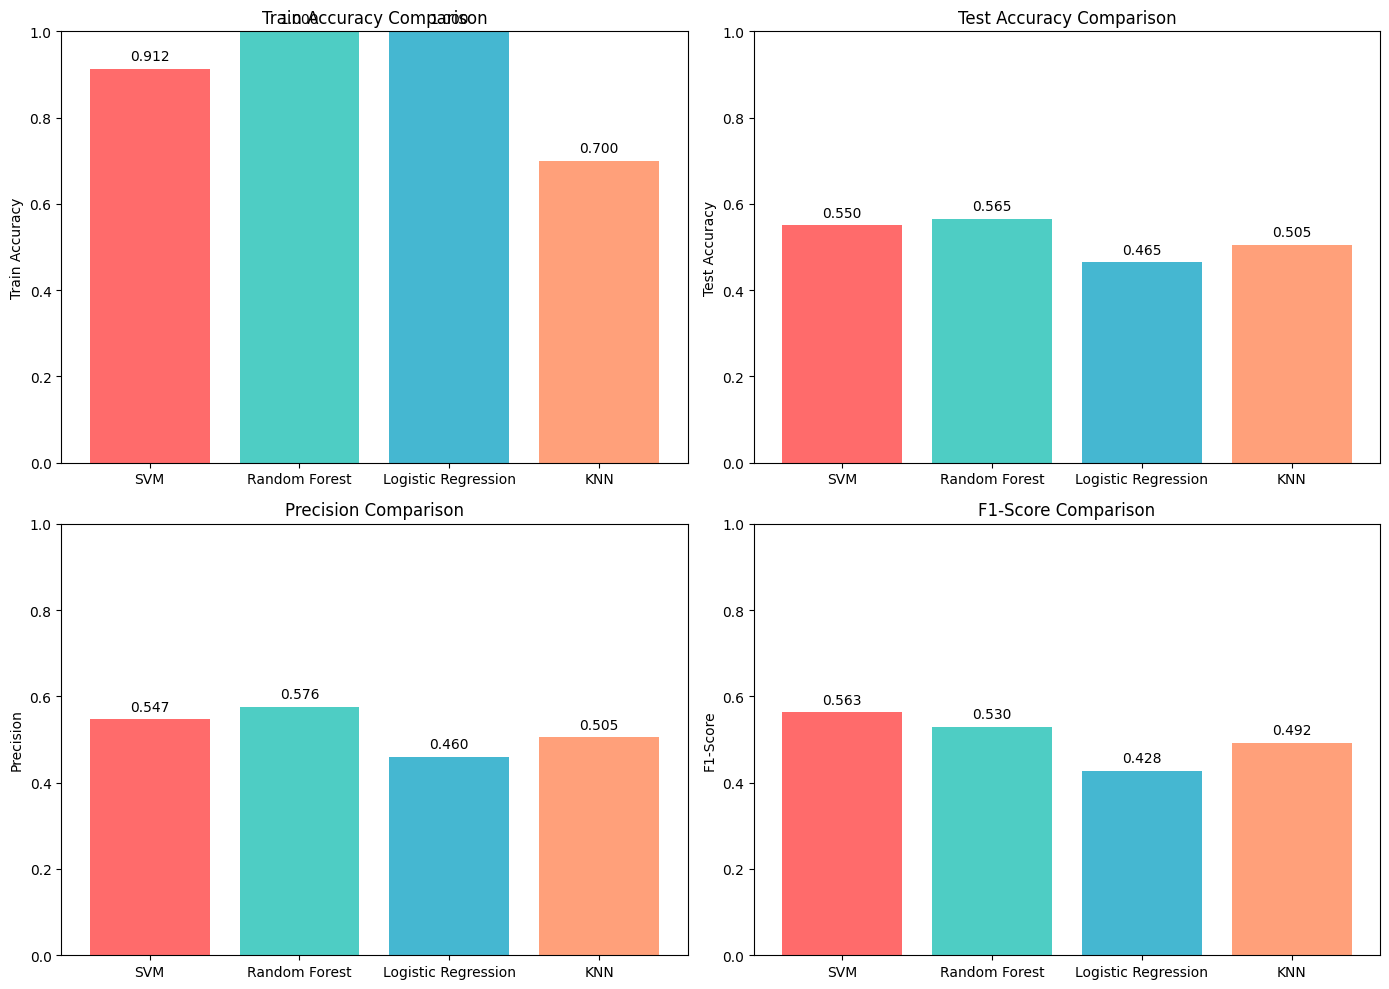

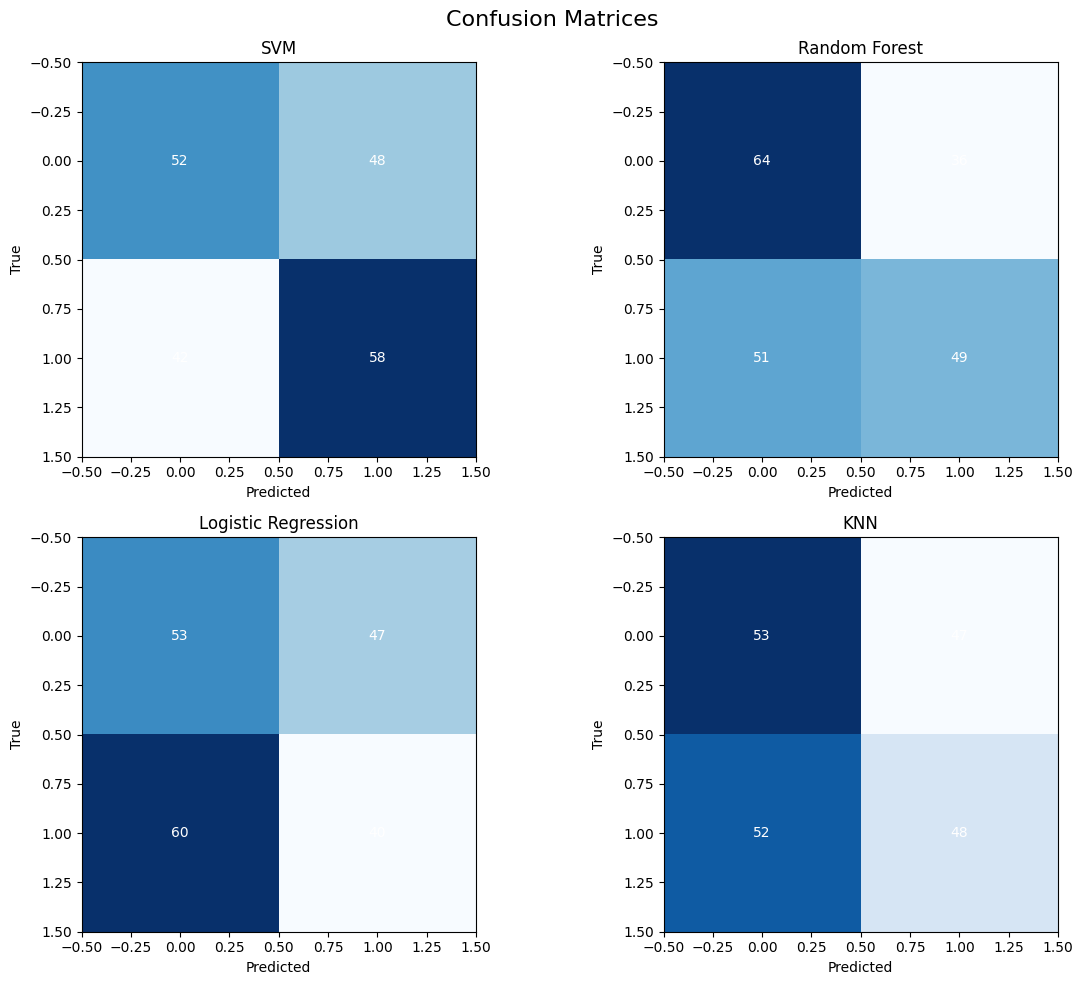

In [25]:
# Evaluate Model Performance
print("=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)

models_performance = {
    'SVM': {
        'Train Accuracy': svm_train_acc,
        'Test Accuracy': svm_test_acc,
        'Precision': precision_score(y_test, svm_test_pred),
        'Recall': recall_score(y_test, svm_test_pred),
        'F1-Score': f1_score(y_test, svm_test_pred)
    },
    'Random Forest': {
        'Train Accuracy': rf_train_acc,
        'Test Accuracy': rf_test_acc,
        'Precision': precision_score(y_test, rf_test_pred),
        'Recall': recall_score(y_test, rf_test_pred),
        'F1-Score': f1_score(y_test, rf_test_pred)
    },
    'Logistic Regression': {
        'Train Accuracy': lr_train_acc,
        'Test Accuracy': lr_test_acc,
        'Precision': precision_score(y_test, lr_test_pred),
        'Recall': recall_score(y_test, lr_test_pred),
        'F1-Score': f1_score(y_test, lr_test_pred)
    },
    'KNN': {
        'Train Accuracy': knn_train_acc,
        'Test Accuracy': knn_test_acc,
        'Precision': precision_score(y_test, knn_test_pred),
        'Recall': recall_score(y_test, knn_test_pred),
        'F1-Score': f1_score(y_test, knn_test_pred)
    }
}

df_performance = pd.DataFrame(models_performance).T
print(df_performance)

# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [models_performance[model][metric] for model in models_performance.keys()]
    ax.bar(models_performance.keys(), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1])
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrices', fontsize=16)

predictions = [svm_test_pred, rf_test_pred, lr_test_pred, knn_test_pred]
model_names = ['SVM', 'Random Forest', 'Logistic Regression', 'KNN']

for idx, (pred, name) in enumerate(zip(predictions, model_names)):
    cm = confusion_matrix(y_test, pred)
    ax = axes[idx // 2, idx % 2]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

In [26]:
# Save Trained Models
import joblib
import os
print("Saving trained models...")

# Create output directory
output_dir = '/content/models'
os.makedirs(output_dir, exist_ok=True)

# Save models
joblib.dump(svm_model, os.path.join(output_dir, 'svm_model.pkl'))
joblib.dump(rf_model, os.path.join(output_dir, 'random_forest_model.pkl'))
joblib.dump(lr_model, os.path.join(output_dir, 'logistic_regression_model.pkl'))
joblib.dump(knn_model, os.path.join(output_dir, 'knn_model.pkl'))

# Save scaler (needed for scaling input in the web app)
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))

print("Models saved successfully!")
print(f"Saved to {output_dir}:")
print("  - svm_model.pkl")
print("  - random_forest_model.pkl")
print("  - logistic_regression_model.pkl")
print("  - knn_model.pkl")
print("  - scaler.pkl")

# Download models to local machine
from google.colab import files
print("\nDownloading models...")
files.download(os.path.join(output_dir, 'svm_model.pkl'))
files.download(os.path.join(output_dir, 'random_forest_model.pkl'))
files.download(os.path.join(output_dir, 'logistic_regression_model.pkl'))
files.download(os.path.join(output_dir, 'knn_model.pkl'))
files.download(os.path.join(output_dir, 'scaler.pkl'))

Saving trained models...
Models saved successfully!
Saved to /content/models:
  - svm_model.pkl
  - random_forest_model.pkl
  - logistic_regression_model.pkl
  - knn_model.pkl
  - scaler.pkl



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cat vs Dog Image Classification using Machine Learning

This notebook trains multiple ML models (SVM, Random Forest, Logistic Regression, KNN) for binary classification of cats and dogs using the Kaggle dataset accessed via Kaggle API.